In [34]:
import warnings
warnings.filterwarnings('ignore')
import requests
import os
import re
import pandas as pd
from bs4 import BeautifulSoup
from string import punctuation
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram

In [40]:
class HeadlineClustering:
    def __init__(self):
        pass
    
    def scrapping(self):
        url = "https://news.google.com/news/headlines?ned=in&hl=en-IN&gl=IN"
        data = requests.get(url)
        soup = BeautifulSoup(data.content,'lxml')
        #lxml can do the same job as html_parser.
        
        path = os.path.abspath(os.path.dirname(''))
        print("#-------------------------------------#")
        print("The path is : {}".format(path))
        print("#-------------------------------------#")
        
        #Now creating a text file to store the headlines in.
        
        filename = os.path.join(path,'data\scrapped_headlines.txt')
        
        links = soup.find_all("a")
        with open(filename,'w',encoding='utf-8') as file:
            for link in links:
                text = link.text
                headline_len = len(text.split())
                if headline_len > 4:
                    file.write(text)
                    file.write('\n')
        file.close()
        
    def preprocessing(self):
        
        path_ = os.path.abspath(os.path.dirname(''))
        file = open(os.path.join(path_,'data\scrapped_headlines.txt'),'rt',encoding='utf-8')
        text_file = file.read().split('\n')
        text_lower = [text.lower() for text in text_file]
        text_letters = [''.join(c for c in text if c not in punctuation) for text in text_lower]
        text_final = [re.sub(r'[^A-Za-z]+',' ',words) for words in text_letters]
        with open(os.path.join(path_,'data\headlines_cleaned.txt'),'w') as fw:
            for text in text_final:
                fw.write(text)
                fw.write('\n')
        fw.close()
        
    def tokenize_and_stem(self,text_file):
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text_file)
        filtered = [w for w in words if w not in stop_words]
        stems = [stemmer.stem(t) for t in filtered]
        return stems
        
    def kmeans_pred(self):
        path_ = os.path.abspath(os.path.dirname(''))
        data = pd.read_csv(os.path.join(path_,'data\headlines_cleaned.txt'),names=['text'])
        stop_words = set(stopwords.words('english'))
        data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
        tfidf_vect = TfidfVectorizer(max_features=200000,use_idf=True,stop_words='english',tokenizer=self.tokenize_and_stem)
        tfidf_matrix = tfidf_vect.fit_transform(data['text'])
        terms = tfidf_vect.get_feature_names()
        
        km = KMeans(n_clusters=7,init='k-means++',max_iter=300,n_init=1,verbose=0,random_state=43)
        km.fit(tfidf_matrix)
        labels = km.labels_
        clusters = labels.tolist()
        distance = 1 - cosine_similarity(tfidf_matrix)
        
        mds = MDS(n_components=2,dissimilarity='precomputed',random_state=42)
        pos = mds.fit_transform(distance)
        xs,ys = pos[:,0],pos[:,1]
        
        for x,y, in zip(xs,ys):
            plt.scatter(x,y)
        plt.title('MDS output of News Headlines')
        plt.savefig(os.path.join(path_, 'results\MDS.png'))
        
        df = pd.DataFrame(dict(label=clusters, data=data['text'], x=xs, y=ys))
        df.to_csv(os.path.join(path_, 'results\kmeans_clustered_DF.txt'), sep=',')
        label_color_map = {0: 'red',
                       1: 'blue',
                       2: 'green',
                       3: 'pink',
                       4: 'purple',
                       5: 'yellow',
                       6: 'orange',
                       7: 'grey'
                       }
        
        csv = open(os.path.join(path_, 'results\kmeans_clustered_output.txt'), 'w')
        csv.write('Cluster     Headline\n')
        
        fig, ax = plt.subplots(figsize=(17, 9))
        
        for index, row in df.iterrows():
            cluster = row['label']
            label_color = label_color_map[row['label']]
            label_text = row['data']
            ax.plot(row['x'], row['y'], marker='o', ms=12, c=label_color)
            row = str(cluster) + ',' + label_text + '\n'
            csv.write(row)
            
        for i in range(len(df)):
            ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['label'], size=8)
            
        plt.title('News Headlines using KMeans Clustering')
        plt.savefig(os.path.join(path_, 'results\kmeans.png'))
        
        
    def hierarchical_pred(self):
        path = os.path.abspath(os.path.dirname(''))
        data = pd.read_csv(os.path.join(path, 'data\headlines_cleaned.txt'), names=['text'])

        stop_words = set(stopwords.words('english'))
        data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

        tfidf_vectorizer = TfidfVectorizer(max_features=200000,use_idf=True,stop_words='english',tokenizer=self.tokenize_and_stem)

        tfidf_matrix = tfidf_vectorizer.fit_transform(data['text'])

        distance = 1 - cosine_similarity(tfidf_matrix)


        linkage_matrix = ward(distance)
        fig, ax = plt.subplots(figsize=(15, 20)) 
        ax = dendrogram(linkage_matrix, orientation="top")
        plt.tight_layout()
        plt.title('News Headlines using Ward Hierarchical Method')
        plt.savefig(os.path.join(path, 'results\hierarchical.png'))
        

#-------------------------------------#
The path is : C:\Users\Avi Gautam\Desktop\Basic projects\Web Scrapping NLP
#-------------------------------------#


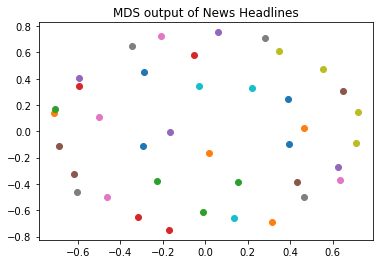

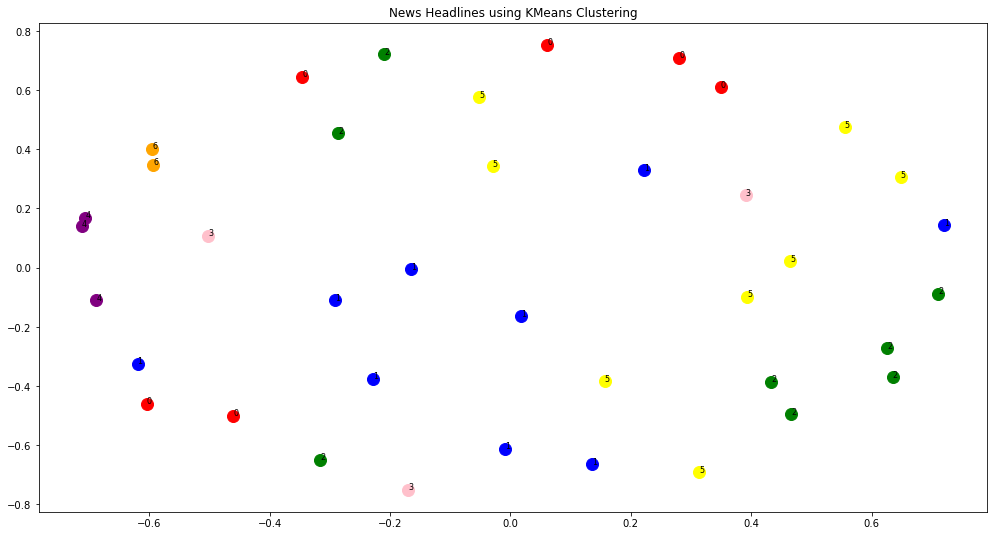

In [41]:
head_clust = HeadlineClustering()
head_clust.scrapping()
head_clust.preprocessing()
head_clust.kmeans_pred()

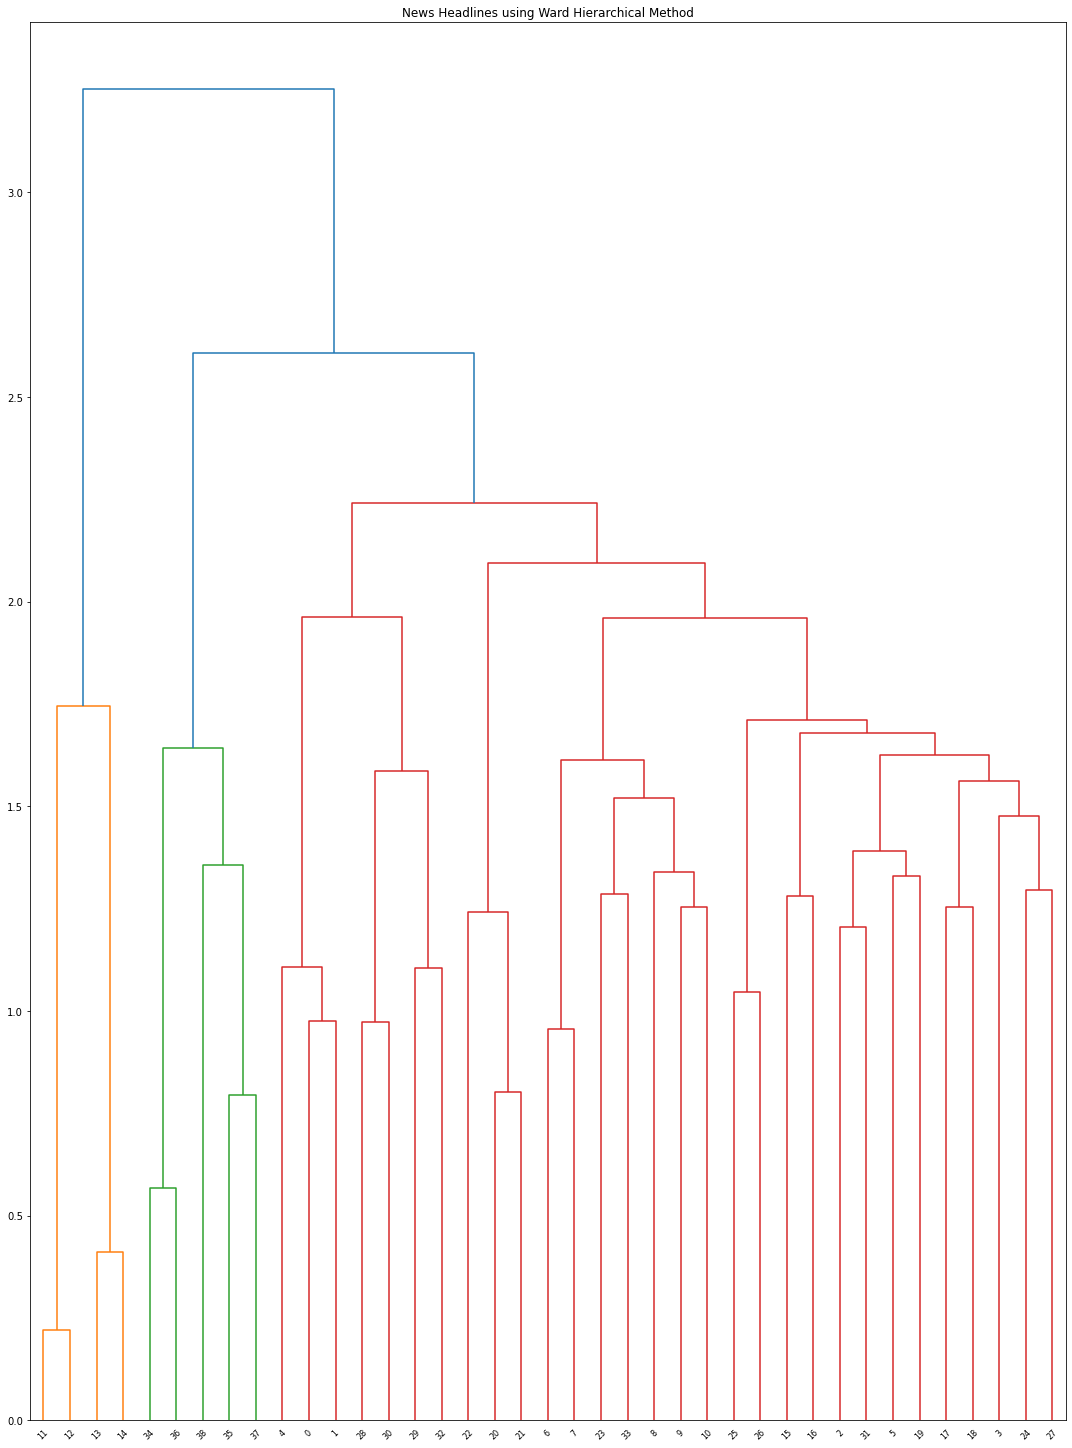

In [42]:
head_clust.hierarchical_pred()